In [19]:
from sympy import *
from sympy.functions.special.spherical_harmonics import Ynm, Ynm_c

init_printing()

k_i, k_j = symbols("k_i k_j", real = True)
psi_a = Function('psi_a')
psi_b = Function('psi_b')


# Slater integral coefficients for radial Hartree-Fock equations

This implements the symbolic calculation of the Slater integrals coefficients. The integrals are as follows.


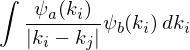

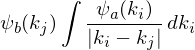

In [22]:
Vd = integrate(psi_a(k_i)*psi_b(k_i)/abs(k_i - k_j), k_i)
Vex = integrate(psi_a(k_i)*psi_b(k_j)/abs(k_i - k_j), k_i)
display(Vd)
display(Vex)

# Averaging

The functions are expanded in a radial part and a spherical harmonic. The integrals below average in angle on the spherical harmonic part, assuming that we can average on spherical harmonics summing up on all m_l for a given shell.


In [3]:


r_i, theta_i, phi_i = symbols("r_i theta_i phi_i", real = True)
r_j, theta_j, phi_j = symbols("r_j theta_j phi_j", real = True)


In [4]:
def calc(lp, mp, l, m, k, km):
    return integrate(
        4*pi/(2*k+1)*Ynm_c(k,km, theta_i, phi_i).expand(func=True)*Ynm(k, km, theta_j, phi_j).expand(func=True)*
                (Ynm_c(lp, mp, theta_j, phi_j).expand(func=True)*Ynm(l, m, theta_j, phi_j).expand(func=True)*
                 # this is multiplying Y_lpmp(i), we can just average over the angles after this product
                 Ynm(lp, mp, theta_i, phi_i).expand(func=True)*
                 # to project it into the Y_lpmp for the (l, m) orbital
                 4*pi*Ynm_c(l, m, theta_i, phi_i).expand(func=True)*
                 sin(theta_j)*                                     # jacobian for integration on dummy j
                 sin(theta_i)                                      # jacobian for integration in i, to average on angle
                ).factor().simplify(),
    (theta_j, 0, pi), (phi_j, 0, 2*pi), (theta_i, 0, pi), (phi_i, 0, 2*pi))/4/pi # averaged here

# this does not average over angle, so we can analytically show that the k!=0 terms for a full shell cancel out
def calcFullShell(lp, mp, l, m, k, km):
    return integrate(
        4*pi/(2*k+1)*Ynm_c(k,km, theta_i, phi_i).expand(func=True)*Ynm(k, km, theta_j, phi_j).expand(func=True)*
                (Ynm_c(lp, mp, theta_j, phi_j).expand(func=True)*Ynm(l, m, theta_j, phi_j).expand(func=True)*
                 Ynm(lp, mp, theta_i, phi_i).expand(func=True)*    # this comes from the wave function
                 sin(theta_j)                                      # jacobian for integration on dummy j
                ).factor().simplify(),
    (theta_j, 0, pi), (phi_j, 0, 2*pi))


In [5]:
def sumK(lp, mp, l, m, k):
    R = 0
    for km in range(-k, k+1):
        R += (calc(lp, mp, l, m, k, km))
    return R

def sumKFullShell(lp, mp, l, m, k):
    R = 0
    for km in range(-k, k+1):
        R += (calcFullShell(lp, mp, l, m, k, km))
    return R


In [6]:
def runVdFullShell():
    for k in [0, 2]:
        for l in [0, 1]:
            R = 0
            for m in range(-l, l+1):
                Ri = sumKFullShell(l, m, l, m, k)
                Ri = Ri/Ynm(l, m, theta_i, phi_i).expand(func=True)
                R += Ri
            print("Vd full shell (%d,%d): %s" % (l, k, R.simplify()/(2*l+1)))
def runVd():
    for k in [0, 2]:
        for l in [0, 1]:
            R = 0
            for m in range(-l, l+1):
                R += (sumK(l, m, l, m, k)).simplify()
            print("Vd averaged over angles (%d,%d): %s" % (l, k, R/(2*l+1)))


In [5]:
runVd()
runVdFullShell()

Vd averaged over angles (0,0): 1
Vd averaged over angles (1,0): 1
Vd averaged over angles (0,2): 0
Vd averaged over angles (1,2): 2/25
Vd full shell (0,0): 1
Vd full shell (1,0): 1
Vd full shell (0,2): 0
Vd full shell (1,2): 0


In [7]:
def runVex():
    for k in [0, 1, 2]:
        for l1 in [0, 1]:
            for l2 in [0, 1]:
                R = 0
                for m1 in range(-l1, l1+1):
                    for m2 in range(-l2, l2+1):
                        R += (sumK(l1, m1, l2, m2, k))
                print("Vex averaged over angles (%d,%d,%d): %s" % (l1, l2, k, R.simplify()/(2*l1+1)/(2*l2+1)))


In [7]:
runVex()

Vex averaged over angles (0,0,0): 1
Vex averaged over angles (0,1,0): 0
Vex averaged over angles (1,0,0): 0
Vex averaged over angles (1,1,0): 1/3
Vex averaged over angles (0,0,1): 0
Vex averaged over angles (0,1,1): 1/3
Vex averaged over angles (1,0,1): 1/3
Vex averaged over angles (1,1,1): 0
Vex averaged over angles (0,0,2): 0
Vex averaged over angles (0,1,2): 0
Vex averaged over angles (1,0,2): 0
Vex averaged over angles (1,1,2): 2/15


# Calculation not averaging on l and m

To compare with page 20 of https://journals.aps.org/pr/pdf/10.1103/PhysRev.34.1293

Here, Vd and Vex are calculated and projected in the orbital being calculated.

In [14]:
def calcVdSplit(l, m, lp, mp, k):
    R = 0
    for km in range(-k, k+1):
        R += integrate(
            4*pi/(2*k+1)*Ynm_c(k,km, theta_i, phi_i).expand(func=True)*Ynm(k, km, theta_j, phi_j).expand(func=True)*
                (Ynm_c(l, m, theta_j, phi_j).expand(func=True)*Ynm(l, m, theta_j, phi_j).expand(func=True)*
                 # this is multiplying Y_lpmp(i), we can just average over the angles after this product
                 Ynm(lp, mp, theta_i, phi_i).expand(func=True)*
                 # to project it into the Y_lprojmproj for the (l_proj, m_proj) orbital
                 4*pi*Ynm_c(lp, mp, theta_i, phi_i).expand(func=True)*
                 sin(theta_j)*                                     # jacobian for integration on dummy j
                 sin(theta_i)                                      # jacobian for integration in i, to average on angle
                ).factor().simplify(),
            (theta_j, 0, pi), (phi_j, 0, 2*pi), (theta_i, 0, pi), (phi_i, 0, 2*pi))/4/pi # averaged here
    return R

def calcVexSplit(l, m, lp, mp, k):
    R = 0
    for km in range(-k, k+1):
        R += integrate(
            4*pi/(2*k+1)*Ynm_c(k,km, theta_i, phi_i).expand(func=True)*Ynm(k, km, theta_j, phi_j).expand(func=True)*
                (Ynm_c(lp, mp, theta_j, phi_j).expand(func=True)*Ynm(l, m, theta_j, phi_j).expand(func=True)*
                 # this is multiplying Y_lpmp(i), we can just average over the angles after this product
                 Ynm(lp, mp, theta_i, phi_i).expand(func=True)*
                 # to project it into the Y_lprojmproj for the (l_proj, m_proj) orbital
                 4*pi*Ynm_c(lp, mp, theta_i, phi_i).expand(func=True)*
                 sin(theta_j)*                                     # jacobian for integration on dummy j
                 sin(theta_i)                                      # jacobian for integration in i, to average on angle
                ).factor().simplify(),
            (theta_j, 0, pi), (phi_j, 0, 2*pi), (theta_i, 0, pi), (phi_i, 0, 2*pi))/4/pi # averaged here
    return R

def runSplit():
    for k in [0, 2, 4]:
        for l1 in [0, 1]:
            for m1 in range(-l1, l1+1):
                for l2 in [0, 1]:
                    for m2 in range(-l2, l2+1):
                        R = (calcVdSplit(l1, m1, l2, m2, k)).simplify()
                        print("a(%d,%d,%d,%d,%d): %s" % (k, l1, m1, l2, m2, R))
    for k in [0, 1, 2, 3, 4]:
        for l1 in [0, 1]:
            for m1 in range(-l1, l1+1):
                for l2 in [0, 1]:
                    for m2 in range(-l2, l2+1):
                        R = (calcVexSplit(l1, m1, l2, m2, k)).simplify()
                        print("b(%d,%d,%d,%d,%d): %s" % (k, l1, m1, l2, m2, R))

runSplit()

a(0,0,0,0,0): 1
a(0,0,0,1,-1): 1
a(0,0,0,1,0): 1
a(0,0,0,1,1): 1
a(0,1,-1,0,0): 1
a(0,1,-1,1,-1): 1
a(0,1,-1,1,0): 1
a(0,1,-1,1,1): 1
a(0,1,0,0,0): 1
a(0,1,0,1,-1): 1
a(0,1,0,1,0): 1
a(0,1,0,1,1): 1
a(0,1,1,0,0): 1
a(0,1,1,1,-1): 1
a(0,1,1,1,0): 1
a(0,1,1,1,1): 1
a(2,0,0,0,0): 0
a(2,0,0,1,-1): 0
a(2,0,0,1,0): 0
a(2,0,0,1,1): 0
a(2,1,-1,0,0): 0
a(2,1,-1,1,-1): 1/25
a(2,1,-1,1,0): -2/25
a(2,1,-1,1,1): 1/25
a(2,1,0,0,0): 0
a(2,1,0,1,-1): -2/25
a(2,1,0,1,0): 4/25
a(2,1,0,1,1): -2/25
a(2,1,1,0,0): 0
a(2,1,1,1,-1): 1/25
a(2,1,1,1,0): -2/25
a(2,1,1,1,1): 1/25
a(4,0,0,0,0): 0
a(4,0,0,1,-1): 0
a(4,0,0,1,0): 0
a(4,0,0,1,1): 0
a(4,1,-1,0,0): 0
a(4,1,-1,1,-1): 0
a(4,1,-1,1,0): 0
a(4,1,-1,1,1): 0
a(4,1,0,0,0): 0
a(4,1,0,1,-1): 0
a(4,1,0,1,0): 0
a(4,1,0,1,1): 0
a(4,1,1,0,0): 0
a(4,1,1,1,-1): 0
a(4,1,1,1,0): 0
a(4,1,1,1,1): 0
b(0,0,0,0,0): 1
b(0,0,0,1,-1): 0
b(0,0,0,1,0): 0
b(0,0,0,1,1): 0
b(0,1,-1,0,0): 0
b(0,1,-1,1,-1): 1
b(0,1,-1,1,0): 0
b(0,1,-1,1,1): 0
b(0,1,0,0,0): 0
b(0,1,0,1,-1): 0
b(0,1,0,1,